In [31]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import geopandas as gpd
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

import os
from os.path import dirname, abspath


In [2]:
DATASET_FOLDER_PATH = os.path.join(dirname(abspath('')), 'data')

source_data = os.path.join(DATASET_FOLDER_PATH, 'historical_fires_extra_features.geojson')
with open(source_data) as file:
    df = gpd.read_file(file)

In [3]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 101650 entries, 0 to 101649
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   FIRE_NUMBER             101650 non-null  object  
 1   FIRE_YEAR               101650 non-null  int64   
 2   IGNITION_DATE           99583 non-null   object  
 3   FIRE_CAUSE              101650 non-null  object  
 4   FIRE_LABEL              101650 non-null  object  
 5   FIRE_CENTRE             101650 non-null  float64 
 6   ZONE                    101650 non-null  float64 
 7   FIRE_ID                 101650 non-null  int64   
 8   FIRE_TYPE               101650 non-null  object  
 9   GEOGRAPHIC_DESCRIPTION  38402 non-null   object  
 10  LATITUDE                101650 non-null  float64 
 11  LONGITUDE               101650 non-null  float64 
 12  CURRENT_SIZE            96894 non-null   float64 
 13  distance_to_campground  101650 non-null  float64 
 

In [4]:
# Apply one-hot encoding to FIRE_CENTRE, ZONE (since they're categorical features)
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_df = pd.DataFrame(encoder.fit_transform(df[['FIRE_CENTRE', 'ZONE']]).toarray())

df = df.join(encoded_df)
df.head()

,FIRE_NUMBER,FIRE_YEAR,IGNITION_DATE,FIRE_CAUSE,FIRE_LABEL,FIRE_CENTRE,ZONE,FIRE_ID,FIRE_TYPE,GEOGRAPHIC_DESCRIPTION,...,28,29,30,31,32,33,34,35,36,37
0,K50756,2013,20130818091300,Person,2013-K50756,5.0,5.0,500756,Nuisance Fire,Darke Lake,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,K51091,2007,20070807110300,Person,2007-K51091,5.0,5.0,501091,Nuisance Fire,Jack Pine Lake,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,K51224,2007,20070818162200,Person,2007-K51224,5.0,5.0,501224,Nuisance Fire,Brenda Lake,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,K51245,2008,20080804121700,Person,2008-K51245,5.0,5.0,501245,Nuisance Fire,Darke lk,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,K50768,2008,20080712143400,Person,2008-K50768,5.0,5.0,500768,Nuisance Fire,Islaht Lake,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
print(df.ZONE.unique())

[ 5.  4.  2.  6.  8.  0. 10. 15.  9.  1. 17. 16.  3.  7. 23. 21. 24. 12.
 14. 22. 19. 20. 11. 13. 18. 27. 25. 60. 99. 28. 42. 26.]


In [6]:
encoder.get_feature_names_out()


array(['FIRE_CENTRE_2.0', 'FIRE_CENTRE_3.0', 'FIRE_CENTRE_4.0',
       'FIRE_CENTRE_5.0', 'FIRE_CENTRE_6.0', 'FIRE_CENTRE_7.0',
       'ZONE_0.0', 'ZONE_1.0', 'ZONE_2.0', 'ZONE_3.0', 'ZONE_4.0',
       'ZONE_5.0', 'ZONE_6.0', 'ZONE_7.0', 'ZONE_8.0', 'ZONE_9.0',
       'ZONE_10.0', 'ZONE_11.0', 'ZONE_12.0', 'ZONE_13.0', 'ZONE_14.0',
       'ZONE_15.0', 'ZONE_16.0', 'ZONE_17.0', 'ZONE_18.0', 'ZONE_19.0',
       'ZONE_20.0', 'ZONE_21.0', 'ZONE_22.0', 'ZONE_23.0', 'ZONE_24.0',
       'ZONE_25.0', 'ZONE_26.0', 'ZONE_27.0', 'ZONE_28.0', 'ZONE_42.0',
       'ZONE_60.0', 'ZONE_99.0'], dtype=object)

In [7]:
df.drop(columns=['FIRE_CENTRE', 'ZONE'], inplace=True)
print(list(df))

['FIRE_NUMBER', 'FIRE_YEAR', 'IGNITION_DATE', 'FIRE_CAUSE', 'FIRE_LABEL', 'FIRE_ID', 'FIRE_TYPE', 'GEOGRAPHIC_DESCRIPTION', 'LATITUDE', 'LONGITUDE', 'CURRENT_SIZE', 'distance_to_campground', 'RAILWAY_TRACK_ID', 'TRACK_CLASSIFICATION', 'USE_TYPE', 'STATUS', 'OPERATOR_ENGLISH_NAME', 'OWNER_NAME', 'SUBDIVISION1_NAME', 'distance_to_railway', 'geometry', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]


In [8]:
df.describe()

,FIRE_YEAR,FIRE_ID,LATITUDE,LONGITUDE,CURRENT_SIZE,distance_to_campground,RAILWAY_TRACK_ID,distance_to_railway,0,1,...,28,29,30,31,32,33,34,35,36,37
count,101650.000000,101650.000000,101650.000000,101650.000000,96894.000000,101650.000000,101650.000000,101650.000000,101650.000000,101650.000000,...,101650.000000,101650.000000,101650.000000,101650.000000,101650.000000,101650.000000,101650.000000,101650.000000,101650.000000,101650.000000
mean,1986.967250,151725.801918,51.187415,-121.648328,36.153995,11340.864521,4879.686995,30342.546503,0.236488,0.070448,...,0.001190,0.003443,0.002204,0.002007,0.000315,0.001722,0.000403,0.000010,0.000010,0.000010
std,20.469768,228087.928336,2.235285,3.176337,1419.657782,12704.225054,2940.529173,46783.504781,0.424927,0.255901,...,0.034481,0.058578,0.046891,0.044754,0.017740,0.041457,0.020079,0.003137,0.003137,0.003137
min,1950.000000,1.000000,48.000000,-139.028000,0.000000,17.330598,3.000000,0.035715,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1969.000000,51.000000,49.510000,-123.690000,0.009000,3802.323445,2452.000000,2156.353920,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1987.000000,284.000000,50.483050,-121.607000,0.100000,7633.388356,4942.000000,11403.212861,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2006.000000,300011.000000,52.140000,-119.595000,0.500000,14600.872437,7406.000000,40333.350928,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2021.000000,990176.000000,60.201000,-112.232000,285935.094000,537291.129755,10049.000000,686888.327957,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
print(list(df))

['FIRE_NUMBER', 'FIRE_YEAR', 'IGNITION_DATE', 'FIRE_CAUSE', 'FIRE_LABEL', 'FIRE_ID', 'FIRE_TYPE', 'GEOGRAPHIC_DESCRIPTION', 'LATITUDE', 'LONGITUDE', 'CURRENT_SIZE', 'distance_to_campground', 'RAILWAY_TRACK_ID', 'TRACK_CLASSIFICATION', 'USE_TYPE', 'STATUS', 'OPERATOR_ENGLISH_NAME', 'OWNER_NAME', 'SUBDIVISION1_NAME', 'distance_to_railway', 'geometry', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]


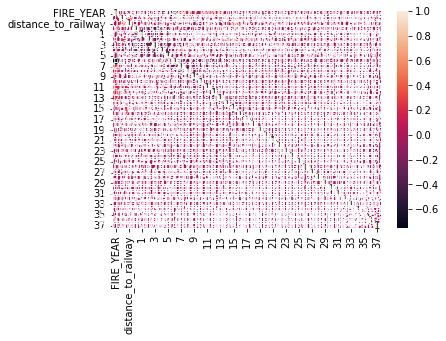

In [35]:
corr_df = df[['FIRE_YEAR', 'distance_to_campground', 'distance_to_railway', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]]

corr_matrix = corr_df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [40]:
corr_matrix[corr_matrix < 1].unstack().transpose().sort_values(ascending=False).drop_duplicates()

distance_to_campground  distance_to_railway    0.319447
distance_to_railway     15                     0.310520
7                       FIRE_YEAR              0.270995
11                      distance_to_railway    0.220391
13                      FIRE_YEAR              0.212924
                                                 ...   
5                       3                     -0.245970
4                       3                     -0.270746
3                       0                     -0.346014
6                       FIRE_YEAR             -0.755082
FIRE_YEAR               FIRE_YEAR                   NaN
Length: 819, dtype: float64

In [9]:
zone_data = os.path.join(DATASET_FOLDER_PATH, 'FIRE_STARTS_PER_ZONE.csv')
with open(zone_data) as file:
    zone_df = pd.read_csv(file)
zone_df['IGNITION_DATE'] = zone_df['IGNITION_DATE'].map(pd.to_datetime)
zone_df['TIMESTAMP'] = zone_df['IGNITION_DATE'].values.astype(np.int64) # 10 ** 9

zone_df.head()


,Unnamed: 0,FIRE_CENTRE,ZONE,IGNITION_DATE,COUNT,TIMESTAMP
0,0,2.0,0.0,1950-05-01,1,-620784000000000000
1,1,2.0,0.0,1950-05-04,1,-620524800000000000
2,2,2.0,0.0,1950-05-12,1,-619833600000000000
3,3,2.0,0.0,1950-05-14,2,-619660800000000000
4,4,2.0,0.0,1950-05-16,7,-619488000000000000


In [10]:
zone_df.drop(columns=['Unnamed: 0', 'IGNITION_DATE'], inplace=True)

In [11]:
zone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81308 entries, 0 to 81307
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FIRE_CENTRE  81308 non-null  float64
 1   ZONE         81308 non-null  float64
 2   COUNT        81308 non-null  int64  
 3   TIMESTAMP    81308 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 2.5 MB


In [12]:
y = zone_df['COUNT']
zone_df.drop(columns=['COUNT'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(zone_df, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [13]:
matrix = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)

xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1)
xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 3.258996


In [41]:
matrix = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)

xg_reg = xgb.XGBRegressor(objective='count:poisson', colsample_bytree=0.3, learning_rate=0.1)
xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
mape = mean_absolute_percentage_error(y_test, preds)
print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))
print("MAPE: %f" % (mape))


RMSE: 3.286397
MAE: 1.316663
MAPE: 0.701976


In [46]:
matrix = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)

xg_reg = xgb.XGBRegressor(objective='count:poisson', colsample_bytree=0.8, learning_rate=0.6)
xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
mape = mean_absolute_percentage_error(y_test, preds)
print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))
print("MAPE: %f" % (mape))

RMSE: 3.010397
MAE: 1.200146
MAPE: 0.617017


In [20]:
matrix = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)

xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.25)
xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 3.186046


In [28]:
matrix = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)

xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.8, learning_rate=0.25)
xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
mape = mean_absolute_percentage_error(y_test, preds)
print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))
print("MAPE: %f" % (mape))

RMSE: 3.085485
MAE: 1.227611
MAPE: 0.634403
